# Introduction

Uma questao pertinente ao se

# Import

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from plotnine import *
from scipy import stats

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Extraction

In [37]:
# Load the dataset
path = "../data/gym_members_exercise_tracking.csv"
df_gym = pd.read_csv(path)

In [38]:
# Display the first few rows to understand the dataset structure
display(df_gym.head())

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


## Transform

In this section, we outline the preprocessing steps taken to prepare our data for analysis.

To streamline the analysis, we will focus exclusively on two key variables: `Workout_Type` and `Calories_Burned`. As such, the DataFrame will be reduced to retain only these columns, removing any unrelated variables.

Following this reduction, we will examine all unique values within the `Workout_Type` column.

In [39]:
df_calories = df_gym[['Calories_Burned', 'Workout_Type']].copy(deep=True)

In [40]:
workout_types = df_gym['Workout_Type'].unique()

print(f"The workout types are: {workout_types}")


The workout types are: ['Yoga' 'HIIT' 'Cardio' 'Strength']


In this dataset, we have four distinct workout types. To better understand their impact on the body, we will classify each as either aerobic or anaerobic based on their primary characteristics:

- **Strength**: Anaerobic
- **Yoga**: Anaerobic
- **Cardio**: Aerobic
- **HIIT**: Aerobic

For most workout types, this classification is straightforward, given their established physiological effects. However, **Yoga** presents a unique case due to its diverse styles, which can vary in intensity and focus.

Most classifications are straightforward, but **Yoga** requires some consideration. While Yoga can vary, many styles—like Power Yoga and Vinyasa—focus more on strength, flexibility, and holding poses than on continuous movement or cardio. This makes it similar to other anaerobic exercises that build strength without sustained, high oxygen demand.

Therefore, in this analysis, we classify Yoga as **anaerobic** based on these qualities.

In [41]:
# Converts workout types to either Aerobic or Anaerobic

dict_convert = {
    'Yoga': 'Anaerobic',
    'HIIT': 'Aerobic',
    'Cardio': 'Aerobic',
    'Strength': 'Anaerobic',
}

df_calories['Workout_Type'] = df_calories['Workout_Type'].map(dict_convert)

display(df_calories.head())


,Calories_Burned,Workout_Type
0,1313.0,Anaerobic
1,883.0,Aerobic
2,677.0,Aerobic
3,532.0,Anaerobic
4,556.0,Anaerobic


# Exploratory Data Analysis

### Evaluating dataset balance and statistics

In [42]:
df_calories.groupby('Workout_Type').count()

,Calories_Burned
Workout_Type,
Aerobic,476
Anaerobic,497


In [43]:
# Prints the statistics for each workout type

print("Statistics for Aerobic workouts")

df_aerobic = df_calories[df_calories['Workout_Type'] == 'Aerobic']
display(df_aerobic.describe())

print("Statistics for Anaerobic workouts")

df_anaerobic = df_calories[df_calories['Workout_Type'] == 'Anaerobic']
display(df_anaerobic.describe())


Statistics for Aerobic workouts


,Calories_Burned
count,476.000000
mean,903.684874
std,272.693322
min,303.000000
25%,728.500000
50%,900.000000
75%,1081.250000
max,1766.000000


Statistics for Anaerobic workouts


,Calories_Burned
count,497.000000
mean,907.086519
std,272.856253
min,330.000000
25%,714.000000
50%,885.000000
75%,1074.000000
max,1783.000000


### Distribution Visualization

#### 1 - Violin Plot

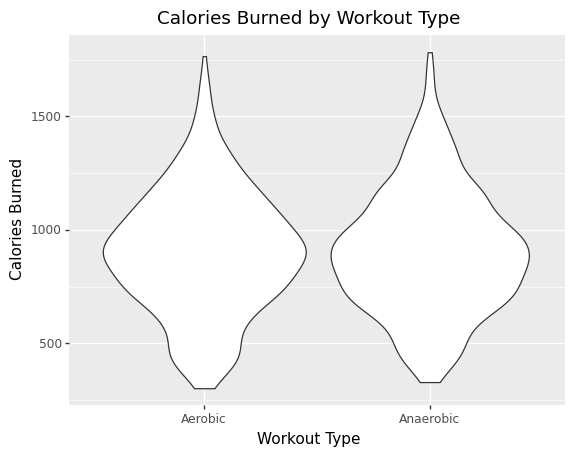

In [44]:

plot = (
    ggplot(df_calories, aes(x='Workout_Type', y='Calories_Burned'))
    + geom_violin()
    + labs(title='Calories Burned by Workout Type', x='Workout Type', y='Calories Burned')
)

print(plot)

#### 2 - Density Plot

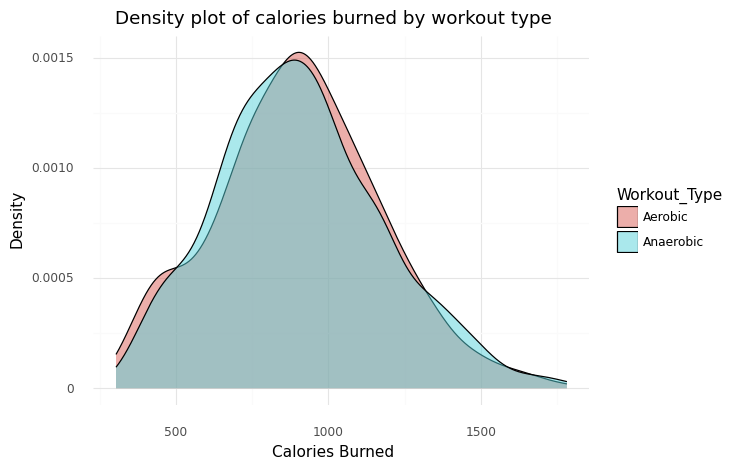

In [45]:
# Plots the distribution of calories burned for each workout type

plot = (
    ggplot(df_calories, aes(x='Calories_Burned', fill='Workout_Type'))
    + geom_density(alpha=0.5)
    + labs(title='Density plot of calories burned by workout type', x='Calories Burned', y='Density')
    + theme_minimal()
)

print(plot)

#### 3 - Histogram

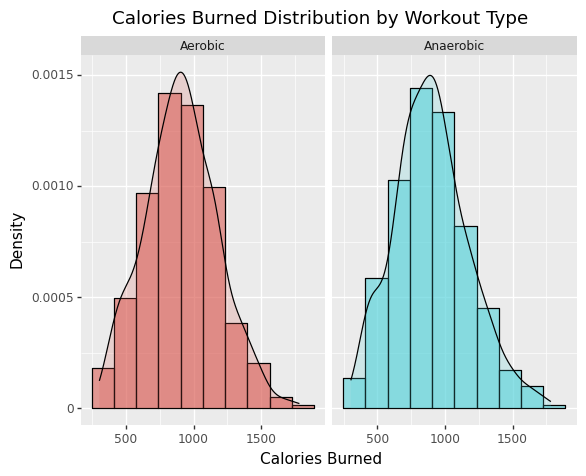

In [62]:
# Histogram with KDE for BMI by Workout Type using facets
plot_histogram_kde = (
    ggplot(df_calories, aes(x="Calories_Burned", fill="Workout_Type"))
    + geom_histogram(aes(y="..density.."), bins=10, alpha=0.6, color="black")
    + geom_density(alpha=0.2)
    + facet_wrap("~Workout_Type")
    + labs(
        title="Calories Burned Distribution by Workout Type",
        x="Calories Burned",
        y="Density"
    )
    + theme(legend_position="none")
)

print(plot_histogram_kde)



In this exploratory data analysis, we observe that both anaerobic and aerobic workout types exhibit similar characteristics in terms of calorie burn. The descriptive statistics for each type—such as mean, median, and standard deviation—are closely aligned, suggesting little variation in calorie expenditure between the two workout categories.

Additionally, the histograms for both workout types show comparable distributions, reinforcing the similarity in their calorie-burning patterns. This visual alignment supports our statistical findings and suggests that neither workout type appears to consistently burn more calories than the other.

However, to formally evaluate this observation, we will proceed with a hypothesis test. This test will help us determine whether there is a statistically significant difference in calories burned between anaerobic and aerobic workouts, thereby allowing us to reach a more rigorous conclusion.


# Hypothesis Testing



In [47]:
# Test Staticis: diff of avg calories burned between Aerobic and Anaerobic workouts

def calc_test_statistic(df):
    aerobic = df[df['Workout_Type'] == 'Aerobic']['Calories_Burned']
    anaerobic = df[df['Workout_Type'] == 'Anaerobic']['Calories_Burned']
    return np.mean(aerobic) - np.mean(anaerobic)

def perm_test(df, n=1000):
    test_stats = []
    for _ in range(n):
        df['Workout_Type'] = np.random.permutation(df['Workout_Type'].values)
        test_stats.append(calc_test_statistic(df))
    return test_stats

observed_test_statistic = calc_test_statistic(df_calories)

test_stats = perm_test(df_calories)

p_value = np.mean(test_stats > observed_test_statistic)

print(f"The p-value is: {p_value}")

# Test Staticis: diff of avg calories burned between Aerobic and Anaerobic workouts


The p-value is: 0.59


In [48]:
# prints the most calories burned in a single workout sorted 

df_gym.sort_values(by='Calories_Burned', ascending=False).head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
910,32,Male,89.8,1.92,199,168,67,1.93,1783.0,Strength,10.6,3.5,4,3,24.36
712,19,Male,82.4,1.96,174,169,62,1.90,1766.0,HIIT,10.1,3.5,5,3,21.45
511,39,Male,86.2,1.82,191,160,72,1.96,1725.0,Strength,10.2,3.5,5,3,26.02
124,26,Male,86.2,1.68,189,157,72,1.97,1701.0,Strength,13.3,3.5,5,3,30.54
90,25,Male,81.5,1.61,170,159,63,1.93,1688.0,HIIT,10.9,3.5,4,3,31.44
